In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from tqdm import tqdm

In [2]:
def create_discriminator():
    d_input = Input(shape=(2,))
    d = Dense(30, activation='relu')(d_input)
    d = Dense(20, activation='relu')(d)
    d = Dense(10, activation='relu')(d)
    d_output = Dense(1, activation='sigmoid')(d)

    discriminator = Model(d_input, d_output)

    discriminator.compile(loss='binary_crossentropy', 
                          optimizer='adam', 
                          metrics=['acc'])
    
    return discriminator

In [3]:
d_test = create_discriminator()
d_test.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 30)                90        
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 931
Trainable params: 931
Non-trainable params: 0
_________________________________________________________________


In [4]:
def create_generator():
    g_input = Input(shape=(10,))
    g = Dense(16, activation='relu')(g_input)
    g = Dense(8, activation='relu')(g)
    g = Dense(4, activation='relu')(g)
    g_output = Dense(2, activation='linear', 
                     kernel_initializer='he_uniform')(g)
    
    generator = Model(g_input, g_output)
    
    return generator

In [5]:
g_test = create_generator()
g_test.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_4 (Dense)             (None, 16)                176       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 4)                 36        
                                                                 
 dense_7 (Dense)             (None, 2)                 10        
                                                                 
Total params: 358
Trainable params: 358
Non-trainable params: 0
_________________________________________________________________


In [6]:
def create_gan(generator, discriminator):
    discriminator.trainable = False

    gan_input = Input(shape=(10,))
    gan = generator(gan_input)
    gan_output = discriminator(gan)
    
    gan = Model(gan_input, gan_output)

    gan.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['acc'])
    
    return gan

In [7]:
gan_test = create_gan(g_test, d_test)
gan_test.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 model_1 (Functional)        (None, 2)                 358       
                                                                 
 model (Functional)          (None, 1)                 931       
                                                                 
Total params: 1,289
Trainable params: 358
Non-trainable params: 931
_________________________________________________________________


In [8]:
def create_real_samples(n_data):
    x_real = np.random.normal(0, 3, n_data)
    y_real = np.sin(x_real)
    
    x_real = x_real.reshape(x_real.shape[0], 1)
    y_real = y_real.reshape(y_real.shape[0], 1)
    
    features_real = np.hstack((x_real, y_real))
    labels_real = np.array([1] * n_data)
    
    return features_real, labels_real

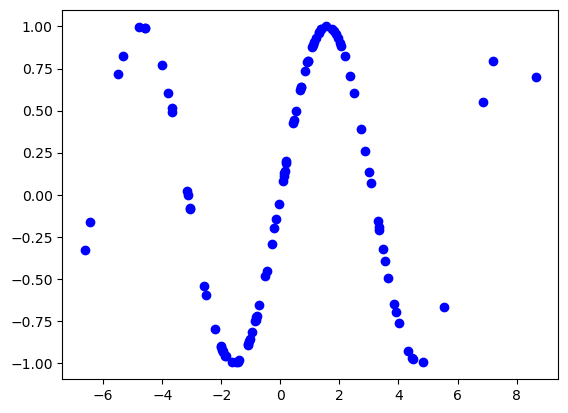

In [9]:
x_line = np.linspace(-7, 7, 1000)
y_line = np.sin(x_line)
#plt.plot(x_line, y_line, c='r', zorder=0)

f_real_test, l_real_test = create_real_samples(100)
plt.scatter(f_real_test[:,0], f_real_test[:,1], c='b')
plt.show()

In [11]:
def create_fake_samples(generator, n_data):
    latent_points = np.random.normal(0, 3, (n_data, 10))
    features_fake = generator.predict(latent_points, verbose=0)
    
    labels_fake = np.array([0] * n_data)
    return features_fake, labels_fake

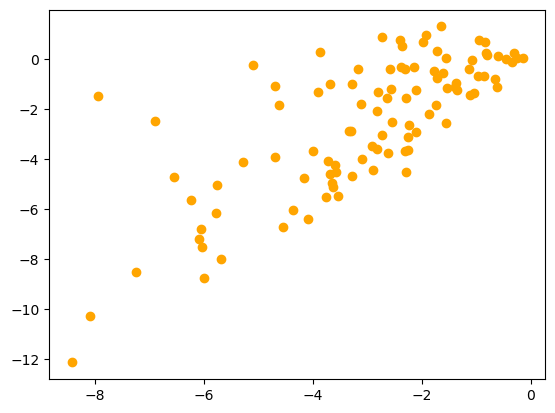

In [12]:
f_fake_test, l_fake_test = create_fake_samples(g_test, 100)
plt.scatter(f_fake_test[:,0], f_fake_test[:,1], c='orange')
plt.show()

In [13]:
def visualize(generator, n_data):
    feats_real, labels_real = create_real_samples(n_data)
    feats_fake, labels_fake = create_fake_samples(generator, 
                                                  n_data)
    
    plt.scatter(feats_real[:,0], feats_real[:,1], c='blue')
    plt.scatter(feats_fake[:,0], feats_fake[:,1], c='orange')
    plt.show()

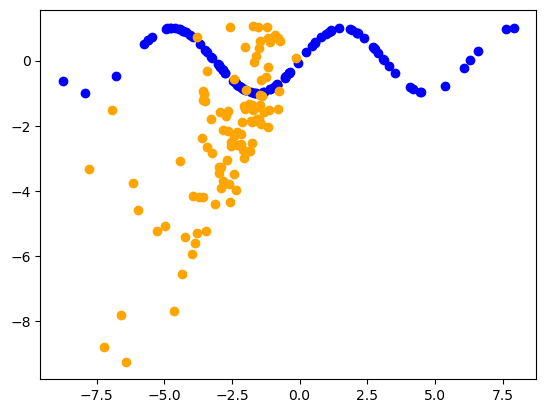

In [14]:
visualize(g_test, 100)

In [15]:
def train(generator, discriminator, gan, epochs, batch_size):
    for i in tqdm(range(epochs)):
        feats_real, labels_real = create_real_samples(batch_size)
        feats_fake, labels_fake = create_fake_samples(generator, batch_size)
        
        discriminator.train_on_batch(feats_real, labels_real)
        discriminator.train_on_batch(feats_fake, labels_fake)
        
        latent_points = np.random.normal(0, 3, (batch_size, 10))
        labels_gan = np.array([1] * batch_size)
        
        gan.train_on_batch(latent_points, labels_gan)
        
        if i == 0:
            visualize(generator, batch_size)
        elif i%1000 == 0:
            visualize(generator, batch_size)

  0%|          | 0/10000 [00:00<?, ?it/s]

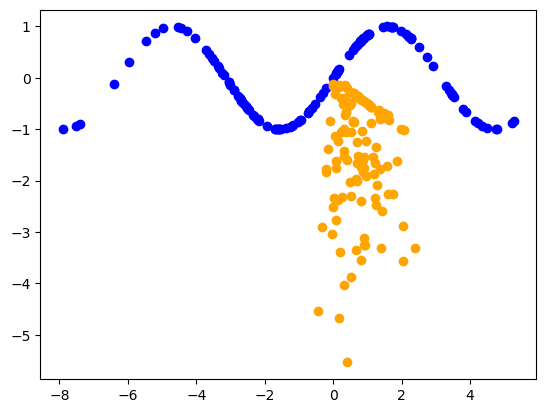

 10%|▉         | 999/10000 [01:26<11:33, 12.98it/s] 

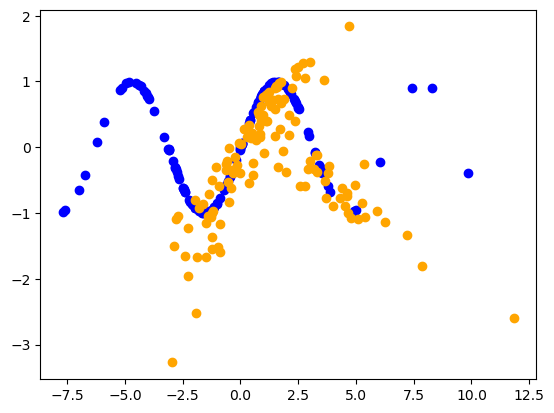

 20%|█▉        | 1999/10000 [02:47<12:44, 10.46it/s]

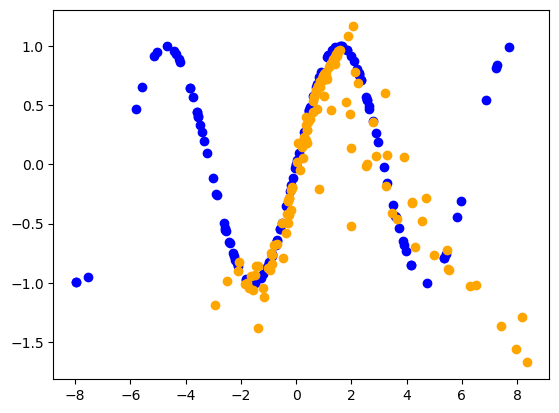

 30%|███       | 3000/10000 [04:07<08:56, 13.04it/s]

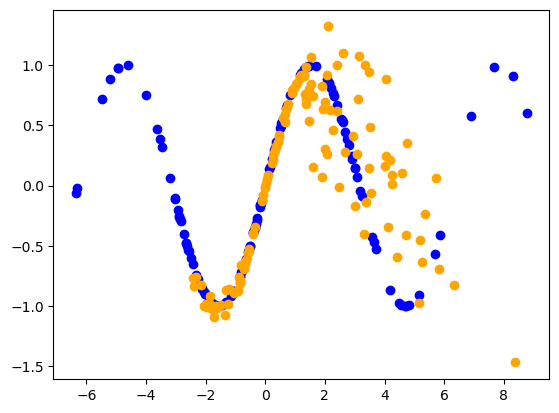

 40%|███▉      | 3999/10000 [05:27<07:41, 13.00it/s]

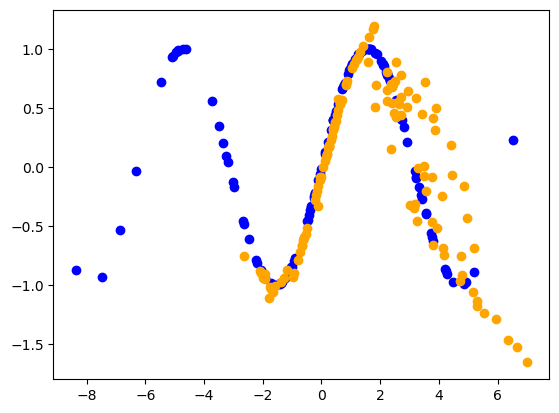

 50%|████▉     | 4999/10000 [06:47<06:41, 12.47it/s]

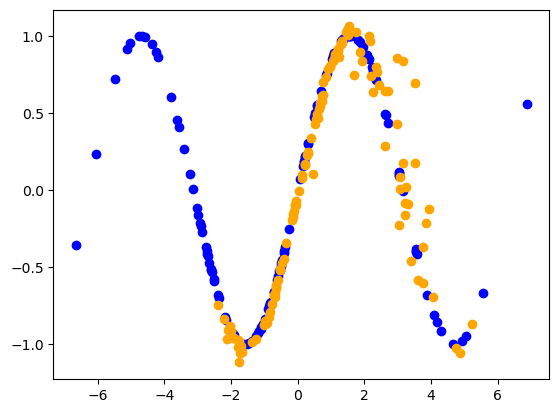

 60%|██████    | 6000/10000 [08:08<05:16, 12.65it/s]

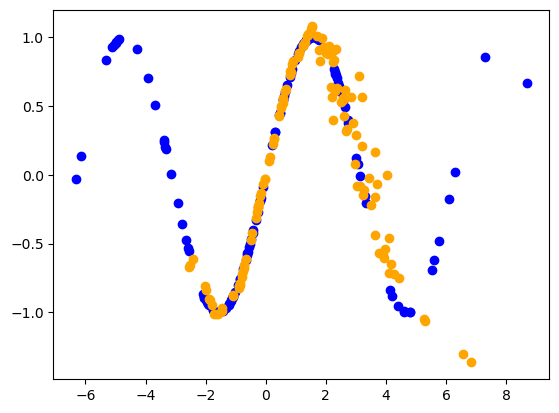

 70%|██████▉   | 6999/10000 [09:28<03:45, 13.32it/s]

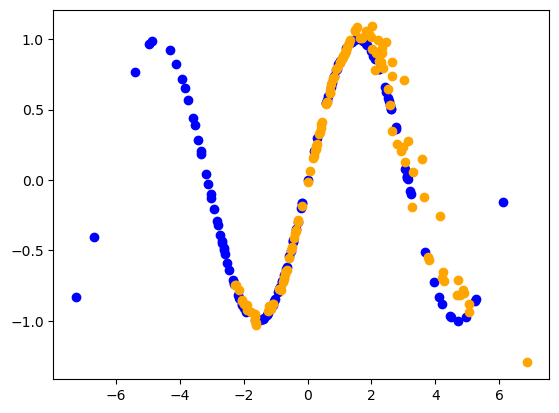

 80%|███████▉  | 7999/10000 [10:48<02:29, 13.37it/s]

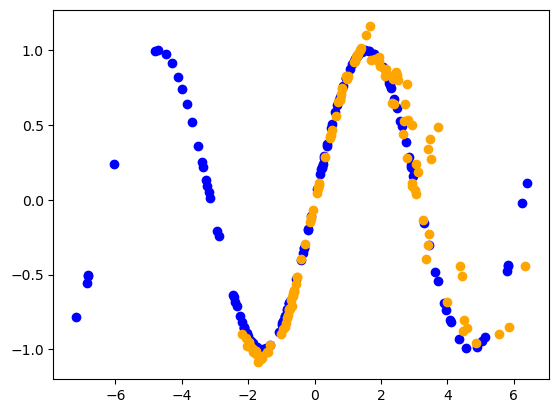

 90%|████████▉ | 8999/10000 [12:07<01:24, 11.82it/s]

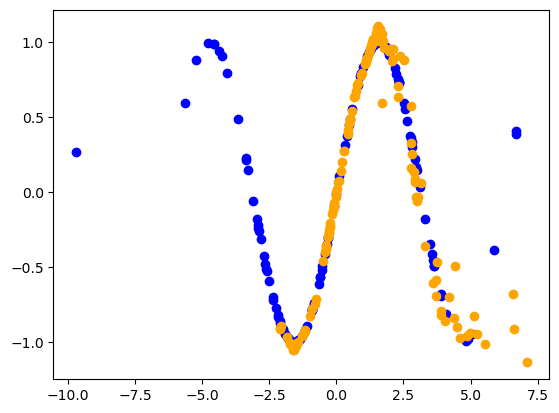

100%|██████████| 10000/10000 [13:26<00:00, 12.40it/s]


In [16]:
EPOCHS = 10000
BATCH_SIZE = 128

discriminator = create_discriminator()x
generator = create_generator()
gan = create_gan(generator, discriminator)

train(generator, discriminator, gan, 
      EPOCHS, BATCH_SIZE)